In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import tensorflow as tf

In [3]:
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [4]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-04-28 14:11:15--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3037::681f:5030, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: 'Food-5K.zip'

Food-5K.zip         100%[===================>] 426.29M  5.40MB/s    in 81s     

2020-04-28 14:12:38 (5.26 MB/s) - 'Food-5K.zip' saved [447001986/447001986]



In [5]:
!unzip -qq -o Food-5K.zip

In [6]:
!ls

01.TF2.0 Intro.ipynb
02.TF2_0_ANN_MNIST.ipynb
03.TF2_0_ANN_Regression.ipynb
04.TF2_0_CNN_CIFAR.ipynb
05.TF2_0_CNN_Fashion_MNIST.ipynb
06.TF2_0_CNN_CIFAR_Improved.ipynb
07.TF2_0_RNN_Autoregressive_Model.ipynb
08.TF2_0_RNN_SimpleRNN_Sine.ipynb
09.TF2_0_RNN_Shapes.ipynb
10.TF2_0_RNN_LSTM_Nonlinear.ipynb
11.TF2_0_RNN_Long_Distance.ipynb
12.TF2_0_RNN_MNIST.ipynb
13.TF2_0_RNN_Stock_Returns.ipynb
14.TF2_0_NLP_Text_Preprocessing.ipynb
15.TF2_0_NLP_Spam_Detection_RNN.ipynb
16.TF2_0_NLP_Spam_Detection_CNN.ipynb
17.TF2_0_Recommender_System.ipynb
18.TF2_0_Transfer_Learning_with_Data_Augmentation.ipynb
19.TF2_0_Transfer_Learning.ipynb
20.TF2_0_GAN.ipynb
Food-5K
Food-5K.zip
__MACOSX
arrhythmia.data
machine_learning_examples
ml-20m
ml-20m.zip
spam.csv


In [7]:
!ls Food-5K/training

0_0.jpg    0_1384.jpg 0_420.jpg  0_807.jpg  1_1192.jpg 1_229.jpg  1_615.jpg
0_1.jpg    0_1385.jpg 0_421.jpg  0_808.jpg  1_1193.jpg 1_23.jpg   1_616.jpg
0_10.jpg   0_1386.jpg 0_422.jpg  0_809.jpg  1_1194.jpg 1_230.jpg  1_617.jpg
0_100.jpg  0_1387.jpg 0_423.jpg  0_81.jpg   1_1195.jpg 1_231.jpg  1_618.jpg
0_1000.jpg 0_1388.jpg 0_424.jpg  0_810.jpg  1_1196.jpg 1_232.jpg  1_619.jpg
0_1001.jpg 0_1389.jpg 0_425.jpg  0_811.jpg  1_1197.jpg 1_233.jpg  1_62.jpg
0_1002.jpg 0_139.jpg  0_426.jpg  0_812.jpg  1_1198.jpg 1_234.jpg  1_620.jpg
0_1003.jpg 0_1390.jpg 0_427.jpg  0_813.jpg  1_1199.jpg 1_235.jpg  1_621.jpg
0_1004.jpg 0_1391.jpg 0_428.jpg  0_814.jpg  1_12.jpg   1_236.jpg  1_622.jpg
0_1005.jpg 0_1392.jpg 0_429.jpg  0_815.jpg  1_120.jpg  1_237.jpg  1_623.jpg
0_1006.jpg 0_1393.jpg 0_43.jpg   0_816.jpg  1_1200.jpg 1_238.jpg  1_624.jpg
0_1007.jpg 0_1394.jpg 0_430.jpg  0_817.jpg  1_1201.jpg 1_239.jpg  1_625.jpg
0_1008.jpg 0_1395.jpg 0_431.jpg  0_818.jpg  1_1202.jpg 1_24.jpg   1_626.jpg
0_1009.jpg 0_

In [8]:
!mv Food-5K/* .

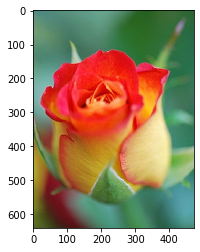

In [9]:
# look at an image for fun
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

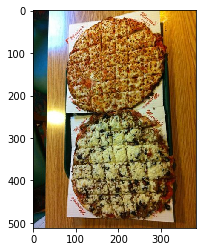

In [10]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [11]:
!mkdir data

In [12]:
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [13]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [14]:
train_path = 'data/train'
valid_path = 'data/test'

In [15]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [16]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [17]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

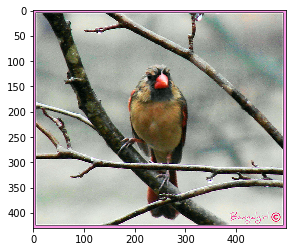

In [18]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [19]:
#VGG16
# from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58892288/58889256 [==============================] - 80s 1us/step


In [20]:
# freeze pretrained model weights
ptm.trainable = False

In [21]:
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded

K = len(folders) # number of classes
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

In [22]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [23]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [24]:
# create an instance of ImageDataGenerator
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

gen_test = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [25]:
batch_size = 128

# create generators
train_generator = gen_train.flow_from_directory(
  train_path,
  shuffle=True,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
valid_generator = gen_test.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Epoch 1/10
19/24 [======================>.......] - ETA: 13:12 - loss: 1.2271 - accuracy: 0.8984

In [ ]:
# create a 2nd train generator which does not use data augmentation

In [ ]:
# create a 2nd train generator which does not use data augmentation
# to get the true train accuracy
train_generator2 = gen_test.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate_generator(
    train_generator2,
    steps=int(np.ceil(len(image_files) / batch_size)))

In [ ]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()